In [1]:
import pandas as pd
import duckdb

In [2]:
# source: https://www.football-data.co.uk/francem.php
# explication des champs: https://www.football-data.co.uk/notes.txt
data = pd.read_csv("data/season-1011_csv.csv")

Ce csv contient les matchs de foot de Ligue1 pour la saison 2011-2012

On aimerait savoir combien de Match Lille a gagné:
- A domicile
- A l'extérieur

In [4]:
data.tail(7)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA
373,F1,29/05/11,Caen,Marseille,2,2,D,2,0,H,...,1.87,1.75,2.16,2.03,19,-0.25,1.92,1.88,2.04,1.99
374,F1,29/05/11,Lille,Rennes,3,2,H,1,1,D,...,1.95,1.86,2.10,1.92,20,-0.75,2.08,2.03,1.87,1.83
375,F1,29/05/11,Lorient,Auxerre,1,2,A,1,1,D,...,2.10,2.00,1.80,1.73,20,-0.25,2.14,2.09,1.83,1.78
376,F1,29/05/11,Monaco,Lyon,0,2,A,0,0,D,...,2.00,1.94,1.91,1.79,17,0.25,1.85,1.80,2.11,2.04
377,F1,29/05/11,Nancy,Lens,4,0,H,2,0,H,...,1.83,1.76,2.14,2.02,20,-1.00,1.73,1.69,2.30,2.21
378,F1,29/05/11,St Etienne,Paris SG,1,1,D,0,0,D,...,1.83,1.78,2.14,2.00,20,0.50,2.17,2.13,1.79,1.76
379,F1,29/05/11,Valenciennes,Nice,2,1,H,0,0,D,...,2.22,2.11,1.75,1.70,20,-0.50,1.95,1.92,1.98,1.95


Pour déterminer que Lille a gagné à domicile, il faut que:
- la HomeTeam soit Lille
- FTHG (pour Full Time Home Goal) soit supérieur à FTAG (Full Time Away Goal: nombre de goal scorés par la "AwayTeam")
- Pour faciliter l'exercice, on ne prends pas le cas de figure où il y a match nul à la 90' minute et qu'un but est inscrit pendant le temps additionnel

On peut savoir facilement que Lille a gagné 13 matchs à Domicile et 8 à  l'extérieur :

In [5]:
print(data.query("HomeTeam == 'Lille' & FTHG > FTAG").shape)
print(data.query("AwayTeam == 'Lille' & FTHG < FTAG").shape)

(13, 70)
(8, 70)


Exercice:
- Utilisez un CASE WHEN pour recenser les cas de figure où lille gagne à domicile (en utilisant la règle ci-dessus)
- Englobez ce CASE WHEN dans un count pour compter le total de victoire à domicile
- Faites la même chose avec les matchs à l'extérieur

Hint: pour faire le count, il faut grouper sur quelque chose. Utilisez "Div": on veut les matchs gagnés en L1.

In [16]:
query_lille = """
SELECT
    Div,
    COUNT(
        CASE WHEN HomeTeam = 'Lille' AND FTHG > FTAG THEN 1 END) AS home_victory, 
    COUNT(
        CASE WHEN AwayTeam = 'Lille' AND FTHG < FTAG THEN 1 END) AS away_victory

FROM data
GROUP BY Div
"""

duckdb.sql(query_lille)

┌─────────┬──────────────┬──────────────┐
│   Div   │ home_victory │ away_victory │
│ varchar │    int64     │    int64     │
├─────────┼──────────────┼──────────────┤
│ F1      │           13 │            8 │
└─────────┴──────────────┴──────────────┘

In [17]:
# %load solutions/5case_when_inside_count_football
query = """
SELECT Div,
    COUNT (
        CASE 
            WHEN data.HomeTeam = 'Lille' AND FTHG > FTAG THEN 1 
        END
    ) AS lille_wins_home,
    COUNT (
        CASE 
            WHEN data.AwayTeam = 'Lille' AND FTHG < FTAG THEN 1 
        END
    ) AS lille_wins_away,
FROM data
GROUP BY Div
"""
duckdb.sql(query)


┌─────────┬─────────────────┬─────────────────┐
│   Div   │ lille_wins_home │ lille_wins_away │
│ varchar │      int64      │      int64      │
├─────────┼─────────────────┼─────────────────┤
│ F1      │              13 │               8 │
└─────────┴─────────────────┴─────────────────┘

---

##### Dans la requete ci-dessus, on compte des 1 mais on peut aussi bien compter n'importe quoi ;)

In [18]:
query = """
SELECT Div,
    COUNT (
        CASE 
            WHEN data.HomeTeam = 'Lille' AND FTHG > FTAG THEN 'WHEREVER' 
        END
    ) AS lille_wins_home,
    COUNT (
        CASE 
            WHEN data.AwayTeam = 'Lille' AND FTHG < FTAG THEN 'WHENEVER' 
        END
    ) AS lille_wins_away,
FROM data
GROUP BY Div
"""
duckdb.sql(query)

┌─────────┬─────────────────┬─────────────────┐
│   Div   │ lille_wins_home │ lille_wins_away │
│ varchar │      int64      │      int64      │
├─────────┼─────────────────┼─────────────────┤
│ F1      │              13 │               8 │
└─────────┴─────────────────┴─────────────────┘

## Mais, on a gagné 13 matchs sur combien exactement ? 

Option 1: utiliser le ELSE

In [25]:
query_lille2 = """
SELECT
    Div,
    AVG(
        CASE
            WHEN HomeTeam = 'Lille' AND FTHG > FTAG THEN 1 
            WHEN HomeTeam = 'Lille' AND FTHG <= FTAG THEN 0 
        END
        ) AS home_victory_pct,
        
    AVG(
        CASE 
            WHEN AwayTeam = 'Lille' AND FTHG < FTAG THEN 1 
            WHEN AwayTeam = 'Lille' AND FTHG >= FTAG THEN 0 
        END
        ) AS away_victory_pct

FROM data
GROUP BY Div
"""

duckdb.sql(query_lille2)

┌─────────┬────────────────────┬─────────────────────┐
│   Div   │  home_victory_pct  │  away_victory_pct   │
│ varchar │       double       │       double        │
├─────────┼────────────────────┼─────────────────────┤
│ F1      │ 0.6842105263157895 │ 0.42105263157894735 │
└─────────┴────────────────────┴─────────────────────┘

In [31]:
query = """
SELECT Div,
    AVG (
        CASE 
            WHEN data.HomeTeam = 'Lille' AND FTHG > FTAG THEN 1 ELSE 0
        END
    ) AS lille_wins_home,
    AVG (
        CASE 
            WHEN data.AwayTeam = 'Lille' AND FTHG < FTAG THEN 1 ELSE 0
        END
    ) AS lille_wins_away,
FROM data
GROUP BY Div
"""

In [32]:
# What ?!
duckdb.sql(query)

┌─────────┬──────────────────────┬──────────────────────┐
│   Div   │   lille_wins_home    │   lille_wins_away    │
│ varchar │        double        │        double        │
├─────────┼──────────────────────┼──────────────────────┤
│ F1      │ 0.034210526315789476 │ 0.021052631578947368 │
└─────────┴──────────────────────┴──────────────────────┘

Enlever l'agrégat pour voir sur quoi on fait les calculs:

In [33]:
query = """
SELECT HomeTeam, AwayTeam, 
        CASE 
            WHEN data.HomeTeam = 'Lille' AND FTHG > FTAG THEN 1 ELSE 0
        END AS lille_wins_home,
        CASE 
            WHEN data.AwayTeam = 'Lille' AND FTHG < FTAG THEN 1 ELSE 0
        END AS lille_wins_away,
FROM data
GROUP BY HomeTeam, AwayTeam, lille_wins_away, lille_wins_home
"""
duckdb.sql(query)

┌──────────────┬──────────────┬─────────────────┬─────────────────┐
│   HomeTeam   │   AwayTeam   │ lille_wins_home │ lille_wins_away │
│   varchar    │   varchar    │      int32      │      int32      │
├──────────────┼──────────────┼─────────────────┼─────────────────┤
│ Rennes       │ Lille        │               0 │               0 │
│ Lorient      │ Nice         │               0 │               0 │
│ Montpellier  │ Caen         │               0 │               0 │
│ Sochaux      │ Paris SG     │               0 │               0 │
│ Valenciennes │ Lens         │               0 │               0 │
│ Brest        │ Valenciennes │               0 │               0 │
│ Lille        │ Montpellier  │               1 │               0 │
│ Paris SG     │ Nice         │               0 │               0 │
│ Lyon         │ Lille        │               0 │               0 │
│ Lorient      │ Arles        │               0 │               0 │
│    ·         │   ·          │               · 

### Exercice: comment faire pour ne pas prendre en compte tous ces matchs qui ne concernent pas Lille ?

On vient de voir que le "ELSE" mets un 0 à tout le reste

Comment pourrait-on procéder pour n'avoir de 0 que quand le match concerne Lille (et que Lille a perdu) ?

In [34]:
query = """
SELECT Div,
    AVG (
        CASE 
            WHEN data.HomeTeam = 'Lille' AND FTHG > FTAG THEN 1
            WHEN data.HomeTeam = 'Lille' AND FTHG <= FTAG THEN 0
        END
    ) AS lille_wins_home,
    AVG (
        CASE 
            WHEN data.AwayTeam = 'Lille' AND FTHG < FTAG THEN 1
            WHEN data.AwayTeam = 'Lille' AND FTHG >= FTAG THEN 0
        END
    ) AS lille_wins_away,
FROM data
GROUP BY Div
"""
duckdb.sql(query)

┌─────────┬────────────────────┬─────────────────────┐
│   Div   │  lille_wins_home   │   lille_wins_away   │
│ varchar │       double       │       double        │
├─────────┼────────────────────┼─────────────────────┤
│ F1      │ 0.6842105263157895 │ 0.42105263157894735 │
└─────────┴────────────────────┴─────────────────────┘

Exercice: refaites la requête sans les AVG() pour inspecter le tableau:

### Alternative: utiliser une CTE ?

In [35]:
query = """
WITH lille_data AS (
    SELECT * FROM data
    WHERE HomeTeam = 'Lille' OR AwayTeam = 'Lille'
)

SELECT Div,
    AVG (
        CASE 
            WHEN lille_data.HomeTeam = 'Lille' AND FTHG > FTAG THEN 1 
            ELSE 0 
        END
    ) AS lille_wins_home,
    AVG (
        CASE 
            WHEN lille_data.AwayTeam = 'Lille' AND FTHG < FTAG THEN 1 
            ELSE 0 
        END
    ) AS lille_wins_away,
FROM lille_data
GROUP BY Div
"""
duckdb.sql(query)

┌─────────┬─────────────────────┬─────────────────────┐
│   Div   │   lille_wins_home   │   lille_wins_away   │
│ varchar │       double        │       double        │
├─────────┼─────────────────────┼─────────────────────┤
│ F1      │ 0.34210526315789475 │ 0.21052631578947367 │
└─────────┴─────────────────────┴─────────────────────┘

Exercice: essayez de comprendre ce qui ne va pas dans cette requete

(Hint: enlever l'agrégation pour avoir le tableau entier pourra vous aider)

#### Solution:

A cause du ELSE 0, <br />
on compte les matchs que Lille a joué à l'extérieur <br />
dans le pourcentage de matchs que lille a gagné à domicile <br />
et vice versa:

In [24]:
query = """
WITH lille_data AS (
    SELECT * FROM data
    WHERE HomeTeam = 'Lille' OR AwayTeam = 'Lille'
)

SELECT Div,
    (
        CASE 
            WHEN lille_data.HomeTeam = 'Lille' AND FTHG > FTAG THEN 1 
            ELSE 0 
        END
    ) AS lille_wins_home,
    (
        CASE 
            WHEN lille_data.AwayTeam = 'Lille' AND FTHG < FTAG THEN 1 
            ELSE 0 
        END
    ) AS lille_wins_away,
FROM lille_data
"""
duckdb.sql(query)

┌─────────┬─────────────────┬─────────────────┐
│   Div   │ lille_wins_home │ lille_wins_away │
│ varchar │      int32      │      int32      │
├─────────┼─────────────────┼─────────────────┤
│ F1      │               0 │               0 │
│ F1      │               0 │               0 │
│ F1      │               1 │               0 │
│ F1      │               1 │               0 │
│ F1      │               0 │               0 │
│ F1      │               1 │               0 │
│ F1      │               1 │               0 │
│ F1      │               1 │               0 │
│ F1      │               0 │               0 │
│ F1      │               1 │               0 │
│ ·       │               · │               · │
│ ·       │               · │               · │
│ ·       │               · │               · │
│ F1      │               0 │               1 │
│ F1      │               0 │               0 │
│ F1      │               0 │               0 │
│ F1      │               0 │           

In [25]:
query = """
WITH lille_data AS (
    SELECT * FROM data
    WHERE HomeTeam = 'Lille' OR AwayTeam = 'Lille'
)

SELECT Div,
    (
        CASE 
            WHEN lille_data.HomeTeam = 'Lille' AND FTHG > FTAG THEN 1 
        END
    ) AS lille_wins_home,
    (
        CASE 
            WHEN lille_data.AwayTeam = 'Lille' AND FTHG < FTAG THEN 1 
        END
    ) AS lille_wins_away,
FROM lille_data
"""
duckdb.sql(query)

┌─────────┬─────────────────┬─────────────────┐
│   Div   │ lille_wins_home │ lille_wins_away │
│ varchar │      int32      │      int32      │
├─────────┼─────────────────┼─────────────────┤
│ F1      │            NULL │            NULL │
│ F1      │            NULL │            NULL │
│ F1      │               1 │            NULL │
│ F1      │               1 │            NULL │
│ F1      │            NULL │            NULL │
│ F1      │               1 │            NULL │
│ F1      │               1 │            NULL │
│ F1      │               1 │            NULL │
│ F1      │            NULL │            NULL │
│ F1      │               1 │            NULL │
│ ·       │               · │               · │
│ ·       │               · │               · │
│ ·       │               · │               · │
│ F1      │            NULL │               1 │
│ F1      │            NULL │            NULL │
│ F1      │            NULL │            NULL │
│ F1      │            NULL │           

###### Conclusion: sans le ELSE 0, ça ne compte que des 1...

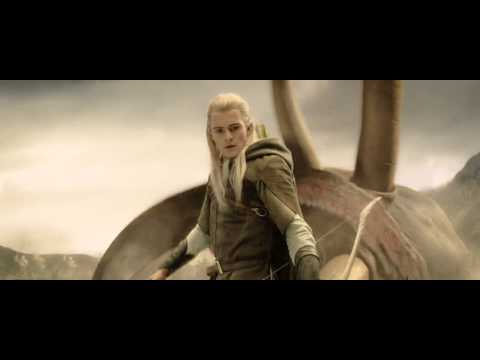

In [13]:
from IPython.display import YouTubeVideo

YouTubeVideo('KjsSvjA5TuE', width=600, height=300)

###### Solution avec une CTE:

In [14]:
query = """
WITH lille_home_data AS (
    SELECT * FROM data
    WHERE HomeTeam = 'Lille'
),
lille_away_data AS (
    SELECT * FROM data
    WHERE AwayTeam = 'Lille'
)

SELECT Div,
    AVG (
        CASE 
            WHEN FTHG > FTAG THEN 1 
            ELSE 0 
        END
    ) AS lille_wins_home,
    
FROM lille_home_data,
GROUP BY Div

UNION  

SELECT Div,
    AVG (
        CASE 
            WHEN FTHG < FTAG THEN 1 
            ELSE 0 
        END
    ) AS lille_wins_away,
FROM lille_away_data,
GROUP BY Div
"""
duckdb.sql(query)

┌─────────┬─────────────────────┐
│   Div   │   lille_wins_home   │
│ varchar │       double        │
├─────────┼─────────────────────┤
│ F1      │ 0.42105263157894735 │
│ F1      │  0.6842105263157895 │
└─────────┴─────────────────────┘

A comparer à notre résultat original.

Parfois, la CTE rends le code plus facile à lire.

Ici, le CASE WHEN au sein de l'agrégation est beaucoup plus lisible:

In [15]:
query = """
SELECT Div,
    AVG (
        CASE 
            WHEN data.HomeTeam = 'Lille' AND FTHG > FTAG THEN 1
            WHEN data.HomeTeam = 'Lille' AND FTHG <= FTAG THEN 0
        END
    ) AS lille_wins_home,
    AVG (
        CASE 
            WHEN data.AwayTeam = 'Lille' AND FTHG < FTAG THEN 1
            WHEN data.AwayTeam = 'Lille' AND FTHG >= FTAG THEN 0
        END
    ) AS lille_wins_away,
FROM data
GROUP BY Div
"""
duckdb.sql(query)

┌─────────┬────────────────────┬─────────────────────┐
│   Div   │  lille_wins_home   │   lille_wins_away   │
│ varchar │       double       │       double        │
├─────────┼────────────────────┼─────────────────────┤
│ F1      │ 0.6842105263157895 │ 0.42105263157894735 │
└─────────┴────────────────────┴─────────────────────┘